
--- Starting Validation ---
Validation Episode 1: Total Reward = 13
Validation Episode 2: Total Reward = 16
Validation Episode 3: Total Reward = 17
Validation Episode 4: Total Reward = 15
Validation Episode 5: Total Reward = 20
Validation Episode 6: Total Reward = 20
Validation Episode 7: Total Reward = 25
Validation Episode 8: Total Reward = 13
Validation Episode 9: Total Reward = 17
Validation Episode 10: Total Reward = 20

Validation Finished. Average Reward: 17.6
Result: SUCCESS - The agent has learned the task!
Saving full training progression to full_validation_movie.gif (this might take a minute)...
Success! Saved to full_validation_movie.gif
[ 1  2  3  4  5  6  7  8  9 10]
[13, 16, 17, 15, 20, 20, 25, 13, 17, 20]


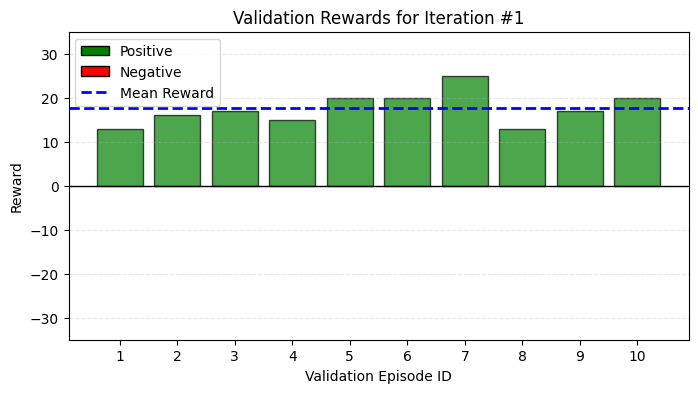

In [ ]:
import numpy as np
import gymnasium as gym
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Patch
import os
from taxi_environment import TaxiEnvironment

def animate_training_progression(all_grids, log_interval=1000, save_path="training_progression.gif", label="Training"):    
    all_frames = []
    episode_labels = []
    for i, episode_frames in enumerate(all_grids):
        episode_num = (i + 1) * log_interval
        for frame in episode_frames:
            all_frames.append(frame)
            episode_labels.append(f"{label} Episode: {episode_num}")
            
    if len(all_frames) == 0:
        print("No frames found to animate.")
        return
    fig, ax = plt.subplots()
    ax.axis('off')
    im = ax.imshow(all_frames[0])
    title = ax.set_title(episode_labels[0])
    def update(frame_idx):
        im.set_array(all_frames[frame_idx])
        title.set_text(episode_labels[frame_idx])
        return [im, title]
    ani = animation.FuncAnimation(
        fig, update, frames=len(all_frames), interval=100, blit=False
    )
    try:
        print(f"Saving full training progression to {save_path} (this might take a minute)...")
        ani.save(save_path, writer='pillow', fps=10)
        print(f"Success! Saved to {save_path}")
    except Exception as e:
        print(f"Error saving animation: {e}")
    finally:
        plt.close(fig)

def plot_all_training(csv_file="training_log.csv"):
    episodes = []
    rewards = []
    window_size = 20
    with open(csv_file, "r") as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if len(row) >= 2:
                episodes.append(int(row[0]))  
                rewards.append(float(row[1]))

    df = pd.DataFrame({'Episode': episodes, 'Reward': rewards})    
    df['Moving_Avg'] = df['Reward'].rolling(window=window_size).mean()
    df['Std_Dev'] = df['Reward'].rolling(window=window_size).std()
    
    plt.figure(figsize=(8, 4))    
    plt.scatter(df['Episode'], df['Reward'], color='gray', alpha=0.3, s=10, label='Raw Reward')    
    plt.plot(df['Episode'], df['Moving_Avg'], color='red', linewidth=2, label='Moving Average')    
    plt.fill_between(df['Episode'], 
                     df['Moving_Avg'] - df['Std_Dev'], 
                     df['Moving_Avg'] + df['Std_Dev'], 
                     color='red', alpha=0.1) 
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Agent Learning Curve for Training")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('training_sma_plot.jpg', format='jpg', dpi=300, bbox_inches='tight')
    
def plot_validation(rewards = [], iteration = 1):
    episodes = np.arange(1, len(rewards) + 1)
    rewards = rewards
    print(episodes)
    print(rewards)
    
    mean_reward = np.mean(rewards)
    
    colors = ['red' if r < 0 else 'green' for r in rewards]

    plt.figure(figsize=(8, 4))
    bars = plt.bar(episodes, rewards, color=colors, edgecolor='black', alpha=0.7)
    plt.axhline(0, color='black', linewidth=1) # The Zero Line
    plt.axhline(mean_reward, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_reward:.1f}')
    
    plt.xticks(episodes)
    plt.xlabel("Validation Episode ID")
    plt.ylabel("Reward")
    plt.title(f"Validation Rewards")
    
    legend_elements = [
        Patch(facecolor='green', edgecolor='black', label='Positive'),
        Patch(facecolor='red', edgecolor='black', label='Negative'),
        plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Reward')
    ]
    plt.legend(handles=legend_elements)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    limit = max(abs(min(rewards)), abs(max(rewards))) + 10
    plt.ylim(-limit, limit)
    
    plt.savefig(f'validation_plot_{iteration}.jpg', format='jpg', dpi=300, bbox_inches='tight')


def train_agent():
    # Hyperparameters
    total_episodes = 25000        
    max_steps = 200               
    learning_rate = 0.1           
    discount_rate = 0.99          
    epsilon = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.01
    decay_rate = 0.0005           
    log_interval = 200

    env = TaxiEnvironment(render_mode="human")
    action_size = env.action_space.n
    state_size = env.observation_space.n
    qtable = np.zeros((state_size, action_size))
    grids = []
    log_filename = "training_log.csv"
    with open(log_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Episode", "Total Reward", "Steps"])
    print("Starting Training")
    for episode in range(total_episodes):
        state, info = env.reset()
        step = 0
        total_rewards = 0
        terminated = False
        truncated = False
        save_episode = (episode + 1) % log_interval == 0
        episode_grids = []
        for step in range(max_steps):
            action_mask = info["action_mask"]
            exp_exp_tradeoff = np.random.uniform(0,1)
            if exp_exp_tradeoff > epsilon:
                # Exploitation: Filter Q-values using mask
                masked_q_values = qtable[state, :].copy()
                masked_q_values[action_mask == 0] = -np.inf
                action = np.argmax(masked_q_values)
            else:
                valid_actions = np.where(action_mask == 1)[0]
                if len(valid_actions) > 0:
                    action = np.random.choice(valid_actions)
                else:
                    action = env.action_space.sample()
                    
            new_state, reward, terminated, truncated, info = env.step(action)            
            if terminated:
                target_q = reward
            else:
                next_action_mask = info["action_mask"]                 
                next_q_values = qtable[new_state, :].copy()
                next_q_values[next_action_mask == 0] = -np.inf                
                target_q = reward + discount_rate * np.max(next_q_values)
                if save_episode:
                    current_grid = env.render()
                    episode_grids.append(current_grid)
            qtable[state, action] += learning_rate * (target_q - qtable[state, action])
            total_rewards += reward
            state = new_state
            if terminated:
                break
        # For Epsilon Greedy Approach
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)
        if save_episode:
            print(f"Episode {episode + 1}: Reward: {total_rewards}, Epsilon: {epsilon:.4f}")
            grids.append(episode_grids)
            with open(log_filename, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow([episode + 1, total_rewards, step])        
    print("Training Finished.")
    return (qtable, grids)

def validate_agent(qtable, num_episodes=5):
    print("\n--- Starting Validation ---")
    env = TaxiEnvironment(render_mode="human")
    max_steps = 50
    total_test_rewards = []
    validation_grids = []
    for episode in range(num_episodes):
        state, info = env.reset()
        step = 0
        episode_reward = 0
        terminated = False
        episode_grids = []
        for step in range(max_steps):
            action_mask = info["action_mask"]
            masked_q_values = qtable[state, :].copy()
            masked_q_values[action_mask == 0] = -np.inf
            action = np.argmax(masked_q_values)
            new_state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            state = new_state
            curr_grid = env.render()
            episode_grids.append(curr_grid)
            if terminated:
                break
        total_test_rewards.append(episode_reward)
        print(f"Validation Episode {episode + 1}: Total Reward = {episode_reward}")
        grids.append(episode_grids)
    avg_reward = np.mean(total_test_rewards)
    print(f"\nValidation Finished. Average Reward: {avg_reward}")
    if avg_reward > 10:
        print("Result: SUCCESS - The agent has learned the task!")
    else:
        print("Result: FAILURE - The agent is still struggling.")
    return (avg_reward, grids, total_test_rewards)

    
# TRAINING
qtable, grids = train_agent()
animate_training_progression(grids, log_interval=1000, save_path="full_training_movie.gif", label="Training")
plot_all_training()

#VALIDATE
avg_reward, validate_grids, total_test_rewards = validate_agent(qtable, 10)
animate_training_progression(validate_grids, log_interval=1, save_path="full_validation_movie.gif", label="Validation")

plot_validation(rewards = total_test_rewards, iteration = 1)

